In [1]:
#importing necessary libraries
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
import random


In [2]:
#initializing the constants 
sample_rate = 22050  
segment_duration = 3 
overlap = 1 
#declaring the file path #replace with your respective dataset location
real_audio_path = "C:\\Users\\91839\\Projects\\Deepfakevoice_detection\\KAGGLE\\AUDIO\\REAL"
fake_audio_path= "C:\\Users\\91839\\Projects\\Deepfakevoice_detection\\KAGGLE\\AUDIO\\FAKE"

# Feature Extraction 

In [7]:
#declaring function to add noise 
def augment_audio_add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    return augmented_audio


In [8]:
#function to extract audio files from dataset 
#pass the audio to noise_augmention method 
#collect the features of audio by passing it to segment_and_extract_features function
def load_audio_files(folder_path, label, sr=sample_rate, augment=False):
    data = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.wav'):
            audio, _ = librosa.load(file_path, sr=sr)
            
            if augment and random.random() < 0.5:
                audio = augment_audio_add_noise(audio, noise_factor=0.005)
            
            data.extend(segment_and_extract_features(audio, label, sr))
    return data


In [10]:
#declaring the method for segmentation and feature extraction of audio file
def segment_and_extract_features(audio, label, sr):

    features = []
    segment_samples = int(segment_duration * sr)
    overlap_samples = int(overlap * sr)
    num_segments = (len(audio) - segment_samples) // (segment_samples - overlap_samples) + 1
    
    for i in range(num_segments):
        start = i * (segment_samples - overlap_samples)
        end = start + segment_samples
        segment = audio[start:end]
        
        mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13)
        chroma = librosa.feature.chroma_stft(y=segment, sr=sr)
        spectral_centroid = librosa.feature.spectral_centroid(y=segment, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=segment, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=segment, sr=sr)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=segment)
        
        feature_dict = {
            'mfcc_mean': np.mean(mfccs, axis=1),
            'mfcc_std': np.std(mfccs, axis=1),
            'chroma': np.mean(chroma, axis=1),
            'spectral_centroid': np.mean(spectral_centroid),
            'spectral_bandwidth': np.mean(spectral_bandwidth),
            'rolloff': np.mean(rolloff),
            'zero_crossing_rate': np.mean(zero_crossing_rate),
            'label': label
        }
        features.append(feature_dict)
    return features


In [11]:
#calling load_audio_file by passing file path and collecting the data of real and fake samples
real_data = load_audio_files(real_audio_path, label='Real', augment=False)
fake_data = load_audio_files(fake_audio_path, label='Fake', augment=True)
all_data = real_data + fake_data


In [12]:
#transforming the combined data of real and fake audio samples as dataframe  
# storing it in json format for retrieval for future training 
df = pd.DataFrame(all_data)
df.to_json('Lib_features_raw.json',index=False)
#df=pd.read_json('Lib_features_raw.json')

# Feature Engineering

In [13]:
#feature engineering the dataframe for crnn-model
X = pd.concat([
    pd.DataFrame(df['mfcc_mean'].tolist()),
    pd.DataFrame(df['mfcc_std'].tolist()),
    pd.DataFrame(df['chroma'].tolist()),
    df[['spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate']]
], axis=1)
y = df['label']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)


In [14]:

# Ensuring all column names are strings
X.columns = X.columns.astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# Model Designing and Training

In [15]:
# creating model with baseline convolutional layer,maxpooling,dropout layers
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(2),
    Dropout(0.2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')
])


In [16]:
#compiling with adam optimizer with accuracy metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
#early stopping introduced 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Training the model with tuned hyperparameters
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20
373/373 [==============================] - 6s 11ms/step - loss: 0.2449 - accuracy: 0.9096 - val_loss: 0.1337 - val_accuracy: 0.9410
Epoch 2/20
373/373 [==============================] - 3s 9ms/step - loss: 0.1316 - accuracy: 0.9458 - val_loss: 0.0904 - val_accuracy: 0.9651
Epoch 3/20
373/373 [==============================] - 3s 8ms/step - loss: 0.0975 - accuracy: 0.9614 - val_loss: 0.0774 - val_accuracy: 0.9702
Epoch 4/20
373/373 [==============================] - 3s 9ms/step - loss: 0.0862 - accuracy: 0.9668 - val_loss: 0.0645 - val_accuracy: 0.9802
Epoch 5/20
373/373 [==============================] - 3s 8ms/step - loss: 0.0762 - accuracy: 0.9710 - val_loss: 0.0595 - val_accuracy: 0.9796
Epoch 6/20
373/373 [==============================] - 3s 8ms/step - loss: 0.0677 - accuracy: 0.9725 - val_loss: 0.0558 - val_accuracy: 0.9762
Epoch 7/20
373/373 [==============================] - 3s 8ms/step - loss: 0.0622 - accuracy: 0.9769 - val_loss: 0.0502 - val_accuracy: 0.9789
Epoch

In [18]:
#displaying the loss and accuracy
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

94/94 [==============================] - 0s 2ms/step - loss: 0.0408 - accuracy: 0.9846
Test Loss: 0.0408, Test Accuracy: 0.9846


# Confusion Matrix Visualization 

In [19]:
# importing the modules for confusion matrix visulization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [20]:
#testing the model on sample dataset 
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


94/94 [==============================] - 1s 5ms/step


In [21]:
# displaying the accuracy and Classification report
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)


Accuracy: 0.9846
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2605
           1       0.94      0.94      0.94       378

    accuracy                           0.98      2983
   macro avg       0.97      0.96      0.97      2983
weighted avg       0.98      0.98      0.98      2983



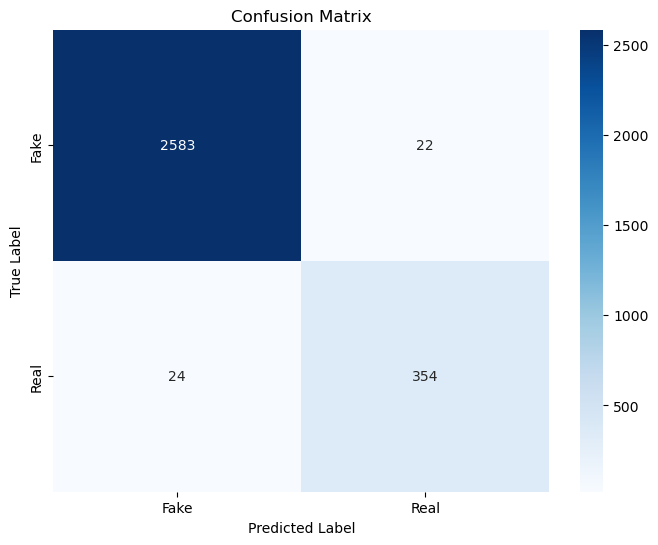

In [22]:
#display the confusion matrix on the plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Audio Sample Classifier - PART 1
The following method will analyze the full audio and return the classification as Real or fake. 
It will work on mono-voice sample only.

In [33]:
# declaring the method for taking a mono voice sample and classifying it as real and fake
def classify_full_audio(model, audio, sr=sample_rate):
    segments = segment_and_extract_features(audio, label=None, sr=sr)
    
    segment_features = pd.concat([
        pd.DataFrame([seg['mfcc_mean'] for seg in segments]),
        pd.DataFrame([seg['mfcc_std'] for seg in segments]),
        pd.DataFrame([seg['chroma'] for seg in segments]),
        pd.DataFrame([[
            seg['spectral_centroid'], 
            seg['spectral_bandwidth'], 
            seg['rolloff'], 
            seg['zero_crossing_rate']] for seg in segments]
        )
    ], axis=1)
    segment_features = scaler.transform(segment_features)
    segment_features = segment_features.reshape(segment_features.shape[0], segment_features.shape[1], 1)
    
    # Predictions for each segment
    segment_predictions = model.predict(segment_features)
    segment_labels = np.argmax(segment_predictions, axis=1)  # Get class indices (0 for Real, 1 for Fake)
    
    # Classify the full audio
    full_audio_prediction = np.argmax(np.bincount(segment_labels))
    return label_encoder.inverse_transform([full_audio_prediction])[0]


In [34]:

# Example
file_path = "C:\\Users\\91839\\Projects\\Deepfakevoice_detection\\Fake_Sample1.wav"
audio, _ = librosa.load(file_path, sr=sample_rate)
full_audio_classification = classify_full_audio(model, audio)
print(f"Full audio classification: {full_audio_classification}")

1/1 [==============================] - 0s 35ms/step
Full audio classification: Fake


c:\Users\91839\Anaconda\envs\dfvoice\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Conversation Classifier - PART 2
The following method will detect if any voice segment in audio is fake, and will return the suitable label instantly.  

In [61]:
import librosa
import numpy as np

def classify_audio_in_segments(model, audio, sr=16000, segment_length=10):
    """
    Classifies an audio file by dividing it into segments and predicting for each segment.

    Args:
        model: Trained classification model.
        audio: Input audio as a NumPy array.
        sr: Sampling rate (default: 16000).
        segment_length: Length of each segment in seconds (default: 10).

    Returns:
        str: "fake" if any segment is classified as fake, otherwise "real".
    """
    # Calculate segment length in samples
    segment_samples = int(segment_length * sr)
    
    # Split the audio into 10-second segments
    num_segments = len(audio) // segment_samples
    is_fake = False
    
    for i in range(num_segments):
        # Extract segment
        start = i * segment_samples
        end = start + segment_samples
        segment = audio[start:end]
        
        # Extract features for the segment
        segments_features = segment_and_extract_features(segment, label=None, sr=sr)
        
        # Prepare features for the model (similar to your code above)
        features = pd.concat([
            pd.DataFrame([seg['mfcc_mean'] for seg in segments_features]),
            pd.DataFrame([seg['mfcc_std'] for seg in segments_features]),
            pd.DataFrame([seg['chroma'] for seg in segments_features]),
            pd.DataFrame([[
                seg['spectral_centroid'], 
                seg['spectral_bandwidth'], 
                seg['rolloff'], 
                seg['zero_crossing_rate']] for seg in segments_features]
            )
        ], axis=1)

        features = scaler.transform(features)
        features = features.reshape(features.shape[0], features.shape[1], 1)
        
        # Predict using the model
        predictions = model.predict(features)
        segment_label = np.argmax(predictions, axis=1)  # 0 for Real, 1 for Fake
        
        # Check if any segment is "fake"
        if 1 in segment_label:
            is_fake = True
            break  # No need to check further
    
    return "fake" if is_fake else "real"


In [63]:
file_path = "C:\\Users\\91839\\Projects\\Deepfakevoice_detection\\Real_Sample1.wav"
audio, _ = librosa.load(file_path, sr=sample_rate)
classify_audio_in_segments(model,audio)


1/1 [==============================] - 0s 39ms/step


c:\Users\91839\Anaconda\envs\dfvoice\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


'real'